In [1]:
"""
File: train_spot.ipynb
Authors: Jared Galloway
Date: 1/15/2020

This Jupyter Notebook will exemplify the workflow for simulating 
a dataset of spots with thier respective annotations - 
then train a neural network to parse out dots from background noise.

Finally, we will import an empirical flurescent microscopy image and
Predict on The image before computing the F1 score as a metric of accuracy.

This Workflow is proof of concepy that spots can be simulted 
easily and accuratly enough to train a convolutional nueral network
on the task of spot detection for a range of empitical scenerios.
"""

'\nFile: train_spot.ipynb\nAuthors: Jared Galloway\nDate: 1/15/2020\n\nThis Jupyter Notebook will exemplify the workflow for simulating \na dataset of spots with thier respective annotations - \nthen train a neural network to parse out dots from background noise.\n\nFinally, we will import an empirical flurescent microscopy image and\nPredict on The image before computing the F1 score as a metric of accuracy.\n\nThis Workflow is proof of concepy that spots can be simulted \neasily and accuratly enough to train a convolutional nueral network\non the task of spot detection for a range of empitical scenerios.\n'

In [2]:
import os
import sys

# External Dependencies
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import time

# Internal Dependencies 
sys.path.insert(0,"../")
import scripts.networks as nets
import scripts.helpers as helpers
import scripts.dot_simulator as dot_simulator

/Users/jaredgalloway/anaconda3/envs/term_project/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/jaredgalloway/anaconda3/envs/term_project/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/jaredgalloway/anaconda3/envs/term_project/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

In [3]:
help(dot_simulator.simulate_single_layers)

Help on function simulate_single_layers in module scripts.dot_simulator:

simulate_single_layers(num_samples=10, width=32, height=32, num_dots_n=5, num_dots_p=0.5, radii_n=3, radii_p=0.85, spot_noise=0.2, point_noise=0.2, background_noise=0.2)
    This function will generate single layer 
    samples of simulated flurescent microscopy images
    along with the respective ground truth annotation. 
    The simulations themselves are defined by:
    
    :param: width, height <int> - The width and height of the simulated images
        defined in number of pixels.
    
    :param: coloc_thresh <int> - This is a number, either 1, 2, or 3 which 
        which primarily affects how we annotate the images as being true positives
        or negative examples. Concretely, this is the threshold of number of layers
        which any dot must colocalize in order to be considered as a synapse.
    
    :param: num_dots_n, num_dots_p <int> - these parameters define the expected 
        binomial dis

In [4]:
# The directory to place output files and location of test files
EXP_DIR = "../scripts/L1-D02-z_490_448_64"

In [6]:
# Choose Some parameters
params = {"num_samples":15,
            "width":64,
            "height":64,
            "num_dots_n": 5,
            "num_dots_p": 0.85,
            "radii_n":4,
            "radii_p":0.65,
            "spot_noise":0.2,
            "point_noise":0.2,
            "background_noise":0.15}

# Simulate!
x, y = dot_simulator.simulate_single_layers(**params)

print(f"simulated data examples has shape: {x.shape}")
print(f"simulated data set targets has shape: {y.shape}")

simulated data examples has shape: (15, 64, 64, 1)
simulated data set targets has shape: (15, 64, 64, 1)


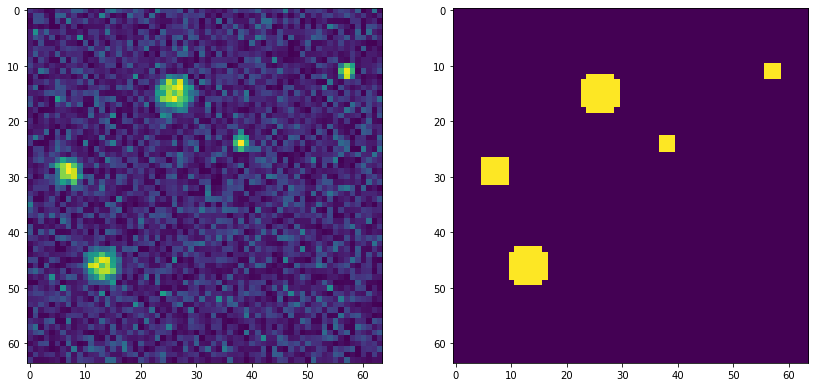

In [10]:
IMAGE_INDEX = 14
fig, ax = plt.subplots(1,2,figsize=(14, 11))
ax[0].imshow(np.squeeze(x[IMAGE_INDEX]))
ax[1].imshow(np.squeeze(y[IMAGE_INDEX]))

In [11]:
# cut data set up into train, validation, and testing.

percent_test = 0.1
percent_validation = 0.2

test_split = int(x.shape[0] * percent_test) 
vali_split = int(x.shape[0] * percent_validation)

test_x = x[:test_split,:,:,:]
vali_x = x[test_split:vali_split,:,:,:]
train_x = x[vali_split:,:,:,:]

test_y = y[:test_split,:,:,:]
vali_y = y[test_split:vali_split,:,:,:]
train_y = y[vali_split:,:,:,:]

In [12]:
# choose a model!
model = nets.deeper_direct_CNN(x,y)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 1)         289       
Total params: 19,393
Trainable params: 19,393
Non-trainable params: 0


In [13]:
# fit the model with our simulated data
model.fit(train_x, train_y, 
        validation_data = (vali_x, vali_y),
        epochs = 2)

Train on 12 samples, validate on 2 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/2
12/12 [==============================] - 0s 36ms/sample - loss: 8.2856 - acc: 0.6464 - val_loss: 1.3366 - val_acc: 0.9767
Epoch 2/2
12/12 [==============================] - 0s 22ms/sample - loss: 8.0346 - acc: 0.9673 - val_loss: 1.2942 - val_acc: 0.9808


In [14]:
# Load an empirical image for testing!
test_emp_image = np.load(f"{EXP_DIR}/{EXP_DIR[11:]}_image_scaled.out", allow_pickle = True)
test_emp_image = np.reshape(test_emp_image,(1,64,64,1))

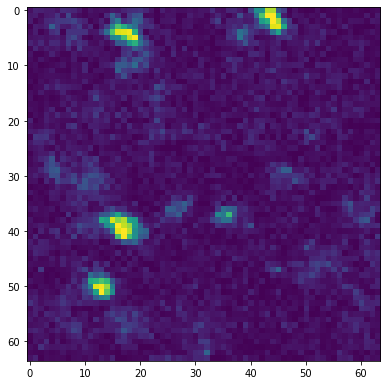

In [15]:
# Lets take a look at the empirical image
# TODO : Take a look at the entire Image.
fig, ax = plt.subplots(1, figsize=(7, 6.5))
ax.imshow(np.squeeze(test_emp_image))

In [16]:
# Finally, lets use our model trained on simulations to predict on the real thing!
pred_emp = model.predict(test_emp_image)
pred_sim = model.predict(test_x)

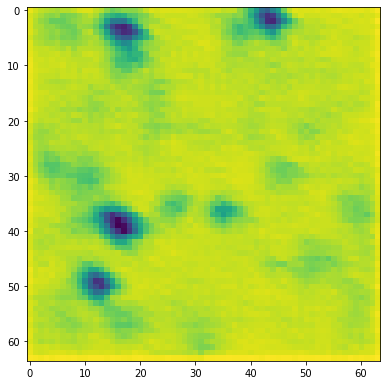

In [17]:
# Lets take a look!
fig, ax = plt.subplots(1, figsize=(7, 6.5))
ax.imshow(np.squeeze(pred_emp))